Here we test the integration of the Hubble parameter $H(z)$ for the GILA model.

In [1]:
#Import libraries related to BAO data.
import numpy as np
from scipy.integrate import solve_ivp
from change_of_parameters import F_H#, omega_luisa_to_CDM

from scipy.constants import c as c_light #meters/seconds
c_light_km = c_light/1000

import time
import os
import git
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
path_datos_global = os.path.dirname(path_git)
os.chdir(path_git)
os.sys.path.append('./fr_mcmc/utils/')
from change_of_parameters import omega_CDM_to_luisa, omega_luisa_to_CDM
from LambdaCDM import H_LCDM_rad
from solve_sys import F_H_prime


Lets define some functions for the calculations of $H(z)$

In [6]:

def get_odes(z, Hubble, params_ode, lcdm=False):
    '''
    Returns the system of ODEs for the given cosmological model.


    Parameters:
    -----------
    z : float
        Redshift value.
    variables : list
        List of values for the dynamical variables.
    physical_params : list
        List of model parameters, where the first n-1 elements are the model parameters,
        while the last one specifies the cosmological model. Mathematically, this information is contained in
        the function Gamma.
    model : str, optional
        Cosmological model that is being integrated. Defaults to 'HS'.

    Returns:
    -----------
    list
        Set of ODEs for the dynamical variables.
    '''    
    #kappa = 8 * np.pi * G_newton / 3
    kappa = 1

    [lamb, L, b, L_bar, H_0, omega_m_0] = params_ode


    #omega_m_0 = 0.999916 #omega_m_0 es el de Luisa
    omega_r_0 = 1 - omega_m_0

    F_H0 = F_H(H_0, [lamb, L, b, L_bar])

    if lcdm == True:
        rho_crit_0 = H_0**2 / kappa        
    else:
        rho_crit_0 = F_H0 / kappa
    #print(omega_m_0,F_H0,rho_crit_0)
    a = 1/(1+z)

    rho_r = rho_crit_0 * omega_r_0 * a**(-4)
    rho_m = rho_crit_0 * omega_m_0 * a**(-3)
    rho_tot =  rho_r + rho_m 
    p_tot =  (1/3) * rho_r

    # To integrate in z
    s =  3 * kappa * (rho_tot + p_tot/c_light_km**2) / ((1+z)*F_H_prime(Hubble, [lamb, L, b, L_bar]))     
    #print(s)
    return s


def integrator_GILA(physical_params, num_z_points=int(10**5),
                initial_z=0, final_z=3,
                system_equations=get_odes, verbose=False,
                method='RK45', rtol=1e-11, atol=1e-16):
 
    t1 = time.time()
    
    L_bar, beta, H0, omega_m_luisa = physical_params
    zs_int = np.linspace(initial_z, final_z, num_z_points)
    ode_params = [0, 1e-27/H0, beta, L_bar/H0, H0, omega_m_luisa]
    sol = solve_ivp(system_equations, (initial_z,final_z),
                    [H0], t_eval=zs_int, args = [ode_params],
                    rtol=rtol, atol=atol, method=method)
        

    assert len(sol.t)==num_z_points, 'Something is wrong with the integration!'
    assert np.all(zs_int==sol.t), 'Not all the values of z coincide with the ones that were required!'

    # Calculate the Hubble parameter
    zs_final = sol.t
    Hs_final = sol.y[0]

    t2 = time.time()

    if verbose == True:
        print('Duration: {} minutes and {} seconds'.format(int((t2-t1)/60),
                int((t2-t1) - 60*int((t2-t1)/60))))

    return zs_final, Hs_final

In [12]:
L_bar = 0.9
H_0 = 70
omega_m = 0.3
beta = 1

omega_m_luisa = omega_CDM_to_luisa(beta, L_bar, H_0, omega_m)
physical_params = [L_bar,beta,H_0,omega_m_luisa]

zs_model, Hs_model = integrator_GILA(physical_params, num_z_points=int(1e5), initial_z = 0, final_z=int(1e4))
#print(zs_model, Hs_model)

Finally, lets compare results

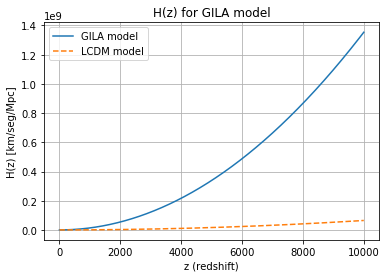

In [13]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.grid()
ax.plot(zs_model, Hs_model,label='GILA model')
ax.plot(zs_model, H_LCDM_rad(zs_model, H_0, omega_m), '--',label='LCDM model')
ax.set_title('H(z) for GILA model')
ax.set_xlabel('z (redshift)')
ax.set_ylabel('H(z) [km/seg/Mpc]')
ax.legend()
plt.show()

Idea: What make the change of sign in $F'(z)$ is the factor $(Ł \cdot H) $ has to be of order $\sim 1$

Ł^{6}

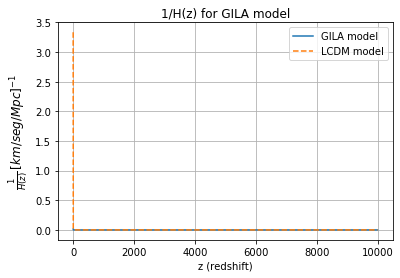

In [5]:
fig, ax = plt.subplots()
ax.grid()
ax.plot(zs_model, 1/Hs_model,label='GILA model')
ax.plot(zs_model, 1/H_LCDM_rad(zs_model, H_0, omega_m), '--', label='LCDM model')
ax.set_title('1/H(z) for GILA model')
ax.set_xlabel('z (redshift)')
ax.set_ylabel(r'$\frac{1}{H(z)}\, [km/seg/Mpc]^{-1}$',size=12)
ax.legend()
plt.show()